In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [151]:
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")

### Rename columns

In [152]:
# lower case column names
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [153]:
# rename columns to pythonic names
df_train = df_train.rename(columns={
    'passengerid': 'passenger_id',
    'survived': 'survived',
    'pclass': 'passenger_class',
    'sibsp': 'sibling_spouse_count',
    'parch': 'parent_child_count',
    'ticket': 'ticket_number',
    'embarked': 'embarked_port',
})

df_test = df_test.rename(columns={
    'passengerid': 'passenger_id',
    'survived': 'survived',
    'pclass': 'passenger_class',
    'sibsp': 'sibling_spouse_count',
    'parch': 'parent_child_count',
    'ticket': 'ticket_number',
    'embarked': 'embarked_port',
})

### Define unnecessary columns

In [154]:
cols_to_drop =['name', 'cabin', 'ticket_number', 'passenger_id']

In [155]:
# check column names
display(df_train.head())
display(df_test.head())

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,passenger_id,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Impute embarked values
Only two missing values, filled in with most common value

In [156]:
df_train["embarked_port"] = df_train["embarked_port"].fillna(df_train["embarked_port"].mode()[0])
df_test["embarked_port"] = df_test["embarked_port"].fillna(df_test["embarked_port"].mode()[0])

In [157]:
# check missing values
display(df_train.isnull().sum())
display(df_test.isnull().sum())

passenger_id              0
survived                  0
passenger_class           0
name                      0
sex                       0
age                     177
sibling_spouse_count      0
parent_child_count        0
ticket_number             0
fare                      0
cabin                   687
embarked_port             0
dtype: int64

passenger_id              0
passenger_class           0
name                      0
sex                       0
age                      86
sibling_spouse_count      0
parent_child_count        0
ticket_number             0
fare                      1
cabin                   327
embarked_port             0
dtype: int64

### Impute age values
Check correlation with age, grouped by columns with high correlation

In [158]:
# fill missing values in age column with grouped median
df_train["age"] = df_train["age"].fillna(df_train.groupby(["passenger_class", "sibling_spouse_count", "parent_child_count"])["age"].transform("median"))
df_test["age"] = df_test["age"].fillna(df_test.groupby(["passenger_class", "sibling_spouse_count", "parent_child_count"])["age"].transform("median"))
# fallback for remaining missing values fill with global age median
df_train["age"] = df_train["age"].fillna(df_train["age"].median())
df_test["age"] = df_test["age"].fillna(df_test["age"].median())

In [159]:
# check missing values
display(df_train['age'].isnull().sum())
display(df_test['age'].isnull().sum())

0

0

In [160]:
df_train.to_csv('../data/processed/train_cleaned.csv', index=False)
df_test.to_csv('../data/processed/test_cleaned.csv', index=False)

### Feature engineering

In [161]:
df_train_clean = pd.read_csv('../data/processed/train_cleaned.csv')
df_test_clean =  pd.read_csv('../data/processed/test_cleaned.csv')

Binning

In [162]:
def survival_summary_by_feature(df, col):
    summary = (
        df.groupby(col)['survived']
        .agg(['count', 'mean'])
        .reset_index()
    )
 
    summary['survival_rate'] = (
        (summary['mean'] * 100)
        .round(1)
        .astype(int)
        .map(lambda x: f"{x}%")
    )
 
    return summary

In [163]:
# Find the cut-off age that best separates children from adults in terms of survival rate
scores = {}

for age in range(5, 21):
    is_child = (df_train_clean["age"] < age).astype(int)
    scores[age] = abs(df_train_clean.groupby(is_child)["survived"].mean().diff().iloc[-1])

best_age = max(scores, key=scores.get)
best_age, scores[best_age]

(7, 0.2792016806722689)

In [164]:
# Define age bins and laels
age_bins = [0, 13, 18, 30, 50, 100]
age_labels = ['child', 'teenager', 'young_adult', 'adult', 'senior']

In [165]:
df_train_clean["age_group"] = pd.cut(
    df_train_clean["age"],
    bins=age_bins,
    labels=age_labels
)

df_train_clean.groupby("age_group")["survived"].mean()
survival_summary_by_feature(df_train_clean, "age_group")

/var/folders/4f/59fr4bzd2knfw4c7yhb7m99c0000gn/T/ipykernel_39753/2655315069.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train_clean.groupby("age_group")["survived"].mean()
/var/folders/4f/59fr4bzd2knfw4c7yhb7m99c0000gn/T/ipykernel_39753/990227488.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)['survived']


,age_group,count,mean,survival_rate
0,child,75,0.560000,56%
1,teenager,70,0.400000,40%
2,young_adult,400,0.325000,32%
3,adult,282,0.425532,42%
4,senior,64,0.343750,34%


In [166]:
df_train_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult


In [167]:
df_test_clean["age_group"] = pd.cut(
    df_test_clean["age"],
    bins=age_bins,
    labels=age_labels
)

In [168]:
df_test_clean.head()

,passenger_id,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adult
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,adult
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,senior
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,young_adult
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,young_adult


`fare_group`

In [169]:
df_train_clean.groupby('passenger_class')['fare'].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_class,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [170]:

df_test_clean.groupby('passenger_class')['fare'].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_class,,,,,,,,
1,107.0,94.280297,84.435858,0.0000,30.10,60.0000,134.5,512.3292
2,93.0,22.202104,13.991877,9.6875,13.00,15.7500,26.0,73.5000
3,217.0,12.459678,10.803698,3.1708,7.75,7.8958,14.4,69.5500


##### Conclusion by looking at 25%/50%/75% quartiles
- Most passenger_class 3 < 16
- Most passenger_class 2 13-28
- Most passenger_class 1 > 31

In [171]:
fare_bins =[0, 16, 30, df_train_clean['fare'].max()]
fare_labels = ['low', 'medium', 'high']
 
df_train_clean["fare_group"] = pd.cut(
    df_train_clean["fare"],
    bins=fare_bins,
    labels=fare_labels,
    include_lowest=True
)

In [172]:
fare_bins =[0, 16, 30, df_test_clean['fare'].max()]
fare_labels = ['low', 'medium', 'high']
 
df_test_clean["fare_group"] = pd.cut(
    df_test_clean["fare"],
    bins=fare_bins,
    labels=fare_labels,
    include_lowest=True
)

In [173]:
survival_summary_by_feature(df_train_clean, "fare_group")

/var/folders/4f/59fr4bzd2knfw4c7yhb7m99c0000gn/T/ipykernel_39753/990227488.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)['survived']


,fare_group,count,mean,survival_rate
0,low,485,0.263918,26%
1,medium,172,0.453488,45%
2,high,234,0.581197,58%


`family_group`

In [174]:
df_train_clean['family_size'] = df_train_clean['sibling_spouse_count'] + df_train_clean['parent_child_count'] + 1
df_test_clean['family_size'] = df_test_clean['sibling_spouse_count'] + df_test_clean['parent_child_count'] + 1

In [175]:
survival_summary_by_feature(df_train_clean, "family_size")

,family_size,count,mean,survival_rate
0,1,537,0.303538,30%
1,2,161,0.552795,55%
2,3,102,0.578431,57%
3,4,29,0.724138,72%
4,5,15,0.200000,20%
5,6,22,0.136364,13%
6,7,12,0.333333,33%
7,8,6,0.000000,0%
8,11,7,0.000000,0%


In [176]:
family_size_bins =[0, 1, 4, 20]
family_size_labels = ['alone', 'small', 'large']

df_train_clean["family_group"] = pd.cut(
    df_train_clean["family_size"],
    bins=family_size_bins,
    labels=family_size_labels
)

df_test_clean["family_group"] = pd.cut(
    df_test_clean["family_size"],
    bins=family_size_bins,
    labels=family_size_labels
)
 

In [177]:
survival_summary_by_feature(df_train_clean, "family_group")

/var/folders/4f/59fr4bzd2knfw4c7yhb7m99c0000gn/T/ipykernel_39753/990227488.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)['survived']


,family_group,count,mean,survival_rate
0,alone,537,0.303538,30%
1,small,292,0.578767,57%
2,large,62,0.161290,16%


In [178]:
df_train_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult,low,2,small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,high,2,small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult,low,1,alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,high,2,small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,low,1,alone


In [179]:
df_test_clean.head()

,passenger_id,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adult,low,1,alone
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,adult,low,2,small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,senior,low,1,alone
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,young_adult,low,1,alone
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,young_adult,low,3,small


Extract `title`

In [180]:
# create new title column
df_train_clean["title"] = df_train_clean["name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()
df_test_clean["title"] = df_test_clean["name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()

In [181]:
title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Other",
    "the Countess": "Other",
    "Dona": "Other",
    "Dr": "Other",
    "Rev": "Other",
    "Col": "Other",
    "Major": "Other",
    "Capt": "Other",
    "Sir": "Other",
    "Jonkheer": "Other",
    "Don": "Other"
}
df_train_clean["title"] = df_train_clean["title"].replace(title_map)
df_test_clean["title"] = df_test_clean["title"].replace(title_map)

In [182]:
df_train_clean["title"].value_counts()

title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

In [183]:
df_train_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult,low,2,small,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,high,2,small,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult,low,1,alone,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,high,2,small,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,low,1,alone,Mr


In [184]:
df_test_clean["title"].value_counts()

title
Mr        240
Miss       79
Mrs        72
Master     21
Other       6
Name: count, dtype: int64

In [185]:
df_test_clean.head()

,passenger_id,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group,title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,adult,low,1,alone,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,adult,low,2,small,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,senior,low,1,alone,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,young_adult,low,1,alone,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,young_adult,low,3,small,Mrs


In [186]:
survival_summary_by_feature(df_train_clean, "title")

,title,count,mean,survival_rate
0,Master,40,0.575000,57%
1,Miss,185,0.702703,70%
2,Mr,517,0.156673,15%
3,Mrs,126,0.793651,79%
4,Other,23,0.347826,34%


### One-hot encoding

In [187]:
cols_to_one_hot_encode = ['title', 'age_group', 'fare_group', 'family_group', 'embarked_port']

# One-hot encode the specified columns
df_train_clean = pd.get_dummies(
    df_train_clean,
    columns=cols_to_one_hot_encode,
    dtype=int,
    drop_first=False
)

df_test_clean = pd.get_dummies(
    df_test_clean,
    columns=cols_to_one_hot_encode,
    dtype=int,
    drop_first=False
)

# Check the new columns
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_id           891 non-null    int64  
 1   survived               891 non-null    int64  
 2   passenger_class        891 non-null    int64  
 3   name                   891 non-null    object 
 4   sex                    891 non-null    object 
 5   age                    891 non-null    float64
 6   sibling_spouse_count   891 non-null    int64  
 7   parent_child_count     891 non-null    int64  
 8   ticket_number          891 non-null    object 
 9   fare                   891 non-null    float64
 10  cabin                  204 non-null    object 
 11  family_size            891 non-null    int64  
 12  title_Master           891 non-null    int64  
 13  title_Miss             891 non-null    int64  
 14  title_Mr               891 non-null    int64  
 15  title_

In [188]:
df_test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_id           418 non-null    int64  
 1   passenger_class        418 non-null    int64  
 2   name                   418 non-null    object 
 3   sex                    418 non-null    object 
 4   age                    418 non-null    float64
 5   sibling_spouse_count   418 non-null    int64  
 6   parent_child_count     418 non-null    int64  
 7   ticket_number          418 non-null    object 
 8   fare                   417 non-null    float64
 9   cabin                  91 non-null     object 
 10  family_size            418 non-null    int64  
 11  title_Master           418 non-null    int64  
 12  title_Miss             418 non-null    int64  
 13  title_Mr               418 non-null    int64  
 14  title_Mrs              418 non-null    int64  
 15  title_

### Binary encode sex to numeric values

In [189]:
print(f"Train: sex before: {df_train_clean['sex'].unique().tolist()}")
df_train_clean["is_female"] = df_train_clean["sex"].map({"male": 0, "female": 1})
print(f"Train: is_female after:  {df_train_clean['is_female'].unique().tolist()}")


print(f"Test: sex before: {df_test_clean['sex'].unique().tolist()}")
df_test_clean["is_female"] = df_test_clean["sex"].map({"male": 0, "female": 1})
print(f"Test: is_female after:  {df_test_clean['is_female'].unique().tolist()}")

Train: sex before: ['male', 'female']
Train: is_female after:  [0, 1]
Test: sex before: ['male', 'female']
Test: is_female after:  [0, 1]


<class 'function'>


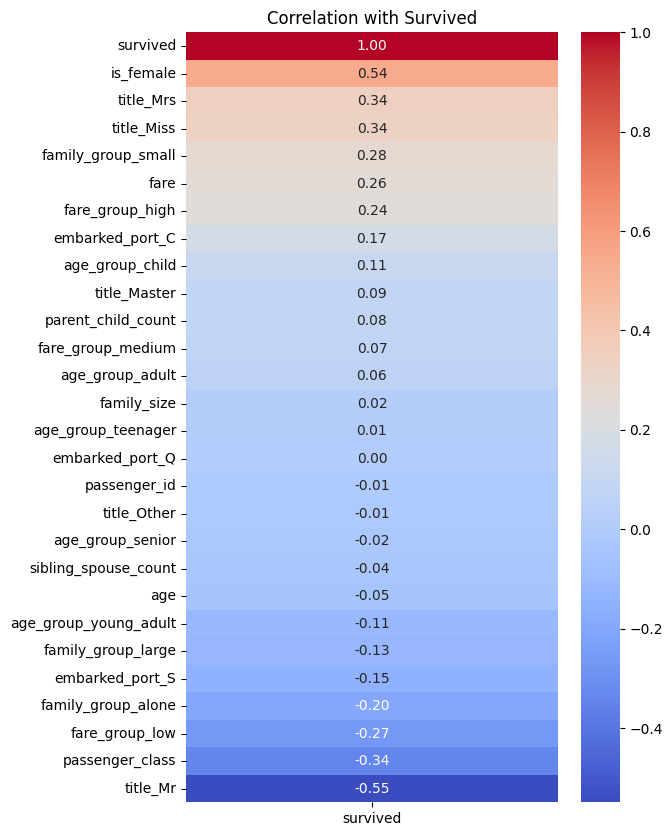

In [190]:
pearson_corr = df_train_clean.corr(numeric_only=True, method='pearson')

corr_target = pearson_corr[["survived"]].sort_values(
    by="survived",
    ascending=False
)
print(type(plt.figure))
plt.figure(figsize=(6, 10))
sns.heatmap(corr_target, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation with Survived")
plt.show()

### Drop unnecessary columns

In [191]:
additional_cols_to_drop = ['sex', 'age', 'sibling_spouse_count', 'parent_child_count', 'fare', 'family_size']

cols_to_drop.extend(additional_cols_to_drop)
print(cols_to_drop)
print(df_train_clean.columns)
print(df_test_clean.columns)

['name', 'cabin', 'ticket_number', 'passenger_id', 'sex', 'age', 'sibling_spouse_count', 'parent_child_count', 'fare', 'family_size']
Index(['passenger_id', 'survived', 'passenger_class', 'name', 'sex', 'age',
       'sibling_spouse_count', 'parent_child_count', 'ticket_number', 'fare',
       'cabin', 'family_size', 'title_Master', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Other', 'age_group_child', 'age_group_teenager',
       'age_group_young_adult', 'age_group_adult', 'age_group_senior',
       'fare_group_low', 'fare_group_medium', 'fare_group_high',
       'family_group_alone', 'family_group_small', 'family_group_large',
       'embarked_port_C', 'embarked_port_Q', 'embarked_port_S', 'is_female'],
      dtype='object')
Index(['passenger_id', 'passenger_class', 'name', 'sex', 'age',
       'sibling_spouse_count', 'parent_child_count', 'ticket_number', 'fare',
       'cabin', 'family_size', 'title_Master', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Other', 'age

## Drop Columns

In [192]:
df_train_clean = df_train_clean.drop(columns=cols_to_drop)

df_train_clean.columns


Index(['survived', 'passenger_class', 'title_Master', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Other', 'age_group_child', 'age_group_teenager',
       'age_group_young_adult', 'age_group_adult', 'age_group_senior',
       'fare_group_low', 'fare_group_medium', 'fare_group_high',
       'family_group_alone', 'family_group_small', 'family_group_large',
       'embarked_port_C', 'embarked_port_Q', 'embarked_port_S', 'is_female'],
      dtype='object')

In [193]:
df_test_clean = df_test_clean.drop(columns=cols_to_drop)

df_test_clean.columns

Index(['passenger_class', 'title_Master', 'title_Miss', 'title_Mr',
       'title_Mrs', 'title_Other', 'age_group_child', 'age_group_teenager',
       'age_group_young_adult', 'age_group_adult', 'age_group_senior',
       'fare_group_low', 'fare_group_medium', 'fare_group_high',
       'family_group_alone', 'family_group_small', 'family_group_large',
       'embarked_port_C', 'embarked_port_Q', 'embarked_port_S', 'is_female'],
      dtype='object')

In [194]:
print(f'Train column : {df_test_clean.shape[1]}')
print(f'Test column : {df_test_clean.shape[1]}')

Train column : 21
Test column : 21


## Split 'train data' and 'test data'

In [195]:
from sklearn.model_selection import train_test_split

X = df_train_clean.drop(columns="survived")
y= df_train_clean["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [196]:
X_train.head()

,passenger_class,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,age_group_child,age_group_teenager,age_group_young_adult,age_group_adult,...,fare_group_low,fare_group_medium,fare_group_high,family_group_alone,family_group_small,family_group_large,embarked_port_C,embarked_port_Q,embarked_port_S,is_female
331,1,0,0,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,0,1,0
733,2,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
382,3,0,0,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
704,3,0,0,1,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0
813,3,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,1


In [197]:
y_train.head()

331    0
733    0
382    0
704    0
813    0
Name: survived, dtype: int64

In [198]:
X_train.shape

(712, 21)

In [199]:
y_train.shape

(712,)

In [200]:
X_test.shape

(179, 21)

In [201]:
y_test.shape

(179,)

## Train model using KNN

In [202]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_prediction =  knn_model.predict(X_test)
accuracy_score =  accuracy_score(y_test, y_prediction)

print(f'Accuracy: {accuracy_score}')

Accuracy: 0.8100558659217877
